## Load libraries

In [167]:
# Libraries to work with dataset
import pandas as pd
import numpy as np

# Libraries to preprocess text
import nltk
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
# from collections import Counter
from rake_nltk import Rake
# import spacy
# import pytextrank
# import pke

# Library to create embeddings
from gensim.models import Word2Vec

# Libraries to select features
from skfeature.utility import construct_W
from skfeature.function.similarity_based import lap_score

# Libraries to cluster data
from sklearn.cluster import KMeans
from sklearn import metrics

# Libraries to visualize data
import seaborn as sns
# from icecream import ic
from tqdm import tqdm     # displaying progress bar while running computation
import matplotlib.pyplot as plt

# Libraries to speed up processing
# import dask.dataframe as dd
# from dask.multiprocessing import get
# import timeit
# import time
# import concurrent.futures
# from functools import partial

# Download neccessary resources
# nltk.download('punkt')
# nltk.download('stopwords')

## Import data

In [6]:
BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"

df_raw = pd.read_csv(INPUT_DIR + "refined_jobpost_data.csv")
pd.set_option('display.max_colwidth', None)

## Explore data

In [7]:
df_raw.shape

(18992, 5)

In [8]:
df_raw.head(3)

,job_id,job_title,job_description,job_requirement,job_qualification
0,1,Chief Financial Officer,"AMERIA Investment Consulting Company is seeking a\r\nChief Financial Officer. This position manages the company's fiscal and\r\nadministrative functions, provides highly responsible and technically\r\ncomplex staff assistance to the Executive Director. The work performed\r\nrequires a high level of technical proficiency in financial management\r\nand investment management, as well as management, supervisory, and\r\nadministrative skills.","- Supervises financial management and administrative staff, including\r\nassigning responsibilities, reviewing employees' work processes and\r\nproducts, counseling employees, giving performance evaluations, and\r\nrecommending disciplinary action;\r\n- Serves as member of management team participating in both strategic\r\nand operational planning for the company;\r\n- Directs and oversees the company's financial management activities,\r\nincluding establishing and monitoring internal controls, managing cash\r\nand investments, and managing the investment portfolio in collaboration\r\nwith the Investment team leader. This includes, but is not limited to,\r\nevaluation of investment risk, concentration risk, fund deployment\r\nlevels, adequacy of loss and liquidity reserves Assists investment team\r\nin development of proper documentation and internal systems;\r\n- Directs and oversees the annual budgeting process, including\r\ndeveloping projections for financial planning, and preparing budgets;\r\n- Prepares external and internal financial management reports, such as\r\naudited financial statements, tax returns, and reports for the board of\r\ndirectors and company staff;\r\n- Develops, implements, and maintains efficient and effective accounting\r\nsystems and controls to ensure compliance with national and\r\ninternational accounting standards and principles, sufficiency of fund\r\naccounting, and comprehensiveness of data for reporting and compliance\r\nrequirements;\r\n- Ensures contract compliance, including interpreting and monitoring\r\ncontracts with clients, submitting required reports, and monitoring\r\ncovenants and other contract terms;\r\n- Oversees the design, implementation and maintenance of computer-based\r\ninformation system. Oversees records retention (both manual and\r\ncomputer-based) and file maintenance activities;\r\n- Serves as company's risk manager, including evaluating loss exposure\r\nand obtaining insurance as appropriate;\r\n- Manages other administrative operations, such as facilities\r\nmanagement, payroll administration, office operations, and\r\nadministrative support;\r\n- Monitors corporate compliance with by-laws and articles of\r\nincorporation regarding corporate registration and reporting of\r\nfundraising operations.","To perform this job successfully, an\r\nindividual must be able to perform each essential duty satisfactorily.\r\nThe requirements listed below are representative of the knowledge,\r\nskill, and/or ability required.\r\nKnowledge of:\r\n- Generally accepted accounting principles;\r\n- Local accounting standards and legislation;\r\n- State reporting requirements pertaining to accounting;\r\n- Principles and practices of financial management and budgeting;\r\n- Principles and practices of financial systems design and analysis;\r\n- Principles and practices of contract management, records management,\r\nand risk management;\r\n- Principles and practices of management and supervision;\r\n- Principles and practices of information systems management.\r\nAbility to:\r\n- Apply sound fiscal and administrative practices to the company's\r\nactivities;\r\n- Plan, organize and supervise the work of subordinate employees,\r\nincluding training them, assigning and evaluating their work, and\r\nproviding job performance feedback;\r\n- Critically analyze fiscal and administrative policies, practices,\r\nprocedures, and systems, and recommend and implemen

In [9]:
df_raw.columns.values

array(['job_id', 'job_title', 'job_description', 'job_requirement',
       'job_qualification'], dtype=object)

### Treating missing data

In [10]:
# Detecting missing values
def missing_values_table(df):

    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_columns = mis_val_table.rename(
        columns={0: "Missing Values", 1: "% of Total Values"}
    )

    # Sort the table by percentage of missing descending
    # .iloc[:, 1]!= 0: filter on missing missing values not equal to zero
    mis_val_table_columns = (
        mis_val_table_columns[mis_val_table_columns.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(2)
    )  # round(2), keep 2 digits
    # Print some summary information
    print(
        "Dataset has {} columns.".format(df.shape[1])
        + "\n"
        + "There are {} columns that have missing values.".format(
            mis_val_table_columns.shape[0]
        )
    )

    # Return the dataframe with missing information
    return mis_val_table_columns

In [11]:
missing_values_table(df_raw)

Dataset has 5 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
job_description,3411,17.96
job_requirement,2508,13.21
job_qualification,472,2.49


<AxesSubplot:>

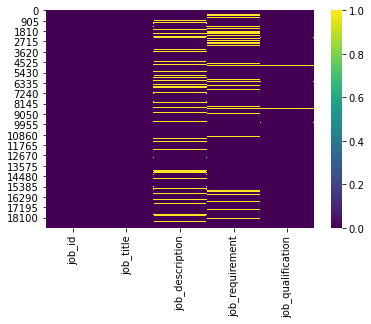

In [12]:
sns.heatmap(df_raw.isnull(), cmap='viridis')

In [13]:
# Replace missing values with "No information"
df = df_raw.copy(deep=True)
df.fillna('Unprovided', inplace=True)
df.head(3)

,job_id,job_title,job_description,job_requirement,job_qualification
0,1,Chief Financial Officer,"AMERIA Investment Consulting Company is seeking a\r\nChief Financial Officer. This position manages the company's fiscal and\r\nadministrative functions, provides highly responsible and technically\r\ncomplex staff assistance to the Executive Director. The work performed\r\nrequires a high level of technical proficiency in financial management\r\nand investment management, as well as management, supervisory, and\r\nadministrative skills.","- Supervises financial management and administrative staff, including\r\nassigning responsibilities, reviewing employees' work processes and\r\nproducts, counseling employees, giving performance evaluations, and\r\nrecommending disciplinary action;\r\n- Serves as member of management team participating in both strategic\r\nand operational planning for the company;\r\n- Directs and oversees the company's financial management activities,\r\nincluding establishing and monitoring internal controls, managing cash\r\nand investments, and managing the investment portfolio in collaboration\r\nwith the Investment team leader. This includes, but is not limited to,\r\nevaluation of investment risk, concentration risk, fund deployment\r\nlevels, adequacy of loss and liquidity reserves Assists investment team\r\nin development of proper documentation and internal systems;\r\n- Directs and oversees the annual budgeting process, including\r\ndeveloping projections for financial planning, and preparing budgets;\r\n- Prepares external and internal financial management reports, such as\r\naudited financial statements, tax returns, and reports for the board of\r\ndirectors and company staff;\r\n- Develops, implements, and maintains efficient and effective accounting\r\nsystems and controls to ensure compliance with national and\r\ninternational accounting standards and principles, sufficiency of fund\r\naccounting, and comprehensiveness of data for reporting and compliance\r\nrequirements;\r\n- Ensures contract compliance, including interpreting and monitoring\r\ncontracts with clients, submitting required reports, and monitoring\r\ncovenants and other contract terms;\r\n- Oversees the design, implementation and maintenance of computer-based\r\ninformation system. Oversees records retention (both manual and\r\ncomputer-based) and file maintenance activities;\r\n- Serves as company's risk manager, including evaluating loss exposure\r\nand obtaining insurance as appropriate;\r\n- Manages other administrative operations, such as facilities\r\nmanagement, payroll administration, office operations, and\r\nadministrative support;\r\n- Monitors corporate compliance with by-laws and articles of\r\nincorporation regarding corporate registration and reporting of\r\nfundraising operations.","To perform this job successfully, an\r\nindividual must be able to perform each essential duty satisfactorily.\r\nThe requirements listed below are representative of the knowledge,\r\nskill, and/or ability required.\r\nKnowledge of:\r\n- Generally accepted accounting principles;\r\n- Local accounting standards and legislation;\r\n- State reporting requirements pertaining to accounting;\r\n- Principles and practices of financial management and budgeting;\r\n- Principles and practices of financial systems design and analysis;\r\n- Principles and practices of contract management, records management,\r\nand risk management;\r\n- Principles and practices of management and supervision;\r\n- Principles and practices of information systems management.\r\nAbility to:\r\n- Apply sound fiscal and administrative practices to the company's\r\nactivities;\r\n- Plan, organize and supervise the work of subordinate employees,\r\nincluding training them, assigning and evaluating their work, and\r\nproviding job performance feedback;\r\n- Critically analyze fiscal and administrative policies, practices,\r\nprocedures, and systems, and recommend and implemen

In [16]:
# title_df = df.loc[1:5, ["job_title"]]
title_df = df[['job_title']]
title_df

,job_title
0,Chief Financial Officer
1,Full-time Community Connections Intern (paid internship)
2,Country Coordinator
3,BCC Specialist
4,Software Developer
...,...
18987,Senior Creative UX/ UI Designer
18988,Category Development Manager
18989,Operational Marketing Manager
18990,Head of Online Sales Department


In [17]:
skill_columns = ["job_description", "job_requirement", "job_qualification"]
# skill_df = df.loc[1:5, skill_columns]
skill_df = df[skill_columns]
skill_df

,job_description,job_requirement,job_qualification
0,"AMERIA Investment Consulting Company is seeking a\r\nChief Financial Officer. This position manages the company's fiscal and\r\nadministrative functions, provides highly responsible and technically\r\ncomplex staff assistance to the Executive Director. The work performed\r\nrequires a high level of technical proficiency in financial management\r\nand investment management, as well as management, supervisory, and\r\nadministrative skills.","- Supervises financial management and administrative staff, including\r\nassigning responsibilities, reviewing employees' work processes and\r\nproducts, counseling employees, giving performance evaluations, and\r\nrecommending disciplinary action;\r\n- Serves as member of management team participating in both strategic\r\nand operational planning for the company;\r\n- Directs and oversees the company's financial management activities,\r\nincluding establishing and monitoring internal controls, managing cash\r\nand investments, and managing the investment portfolio in collaboration\r\nwith the Investment team leader. This includes, but is not limited to,\r\nevaluation of investment risk, concentration risk, fund deployment\r\nlevels, adequacy of loss and liquidity reserves Assists investment team\r\nin development of proper documentation and internal systems;\r\n- Directs and oversees the annual budgeting process, including\r\ndeveloping projections for financial planning, and preparing budgets;\r\n- Prepares external and internal financial management reports, such as\r\naudited financial statements, tax returns, and reports for the board of\r\ndirectors and company staff;\r\n- Develops, implements, and maintains efficient and effective accounting\r\nsystems and controls to ensure compliance with national and\r\ninternational accounting standards and principles, sufficiency of fund\r\naccounting, and comprehensiveness of data for reporting and compliance\r\nrequirements;\r\n- Ensures contract compliance, including interpreting and monitoring\r\ncontracts with clients, submitting required reports, and monitoring\r\ncovenants and other contract terms;\r\n- Oversees the design, implementation and maintenance of computer-based\r\ninformation system. Oversees records retention (both manual and\r\ncomputer-based) and file maintenance activities;\r\n- Serves as company's risk manager, including evaluating loss exposure\r\nand obtaining insurance as appropriate;\r\n- Manages other administrative operations, such as facilities\r\nmanagement, payroll administration, office operations, and\r\nadministrative support;\r\n- Monitors corporate compliance with by-laws and articles of\r\nincorporation regarding corporate registration and reporting of\r\nfundraising operations.","To perform this job successfully, an\r\nindividual must be able to perform each essential duty satisfactorily.\r\nThe requirements listed below are representative of the knowledge,\r\nskill, and/or ability required.\r\nKnowledge of:\r\n- Generally accepted accounting principles;\r\n- Local accounting standards and legislation;\r\n- State reporting requirements pertaining to accounting;\r\n- Principles and practices of financial management and budgeting;\r\n- Principles and practices of financial systems design and analysis;\r\n- Principles and practices of contract management, records management,\r\nand risk management;\r\n- Principles and practices of management and supervision;\r\n- Principles and practices of information systems management.\r\nAbility to:\r\n- Apply sound fiscal and administrative practices to the company's\r\nactivities;\r\n- Plan, organize and supervise the work of subordinate employees,\r\nincluding training them, assigning and evaluating their work, and\r\nproviding job performance feedback;\r\n- Critically analyze fiscal and administrative policies, practices,\r\nprocedures, and systems, and recommend and implement changes as needed;\r\n- Gather and synthe

## Text preprocessing

- Removing URL
- Lowercasing
- Removing irrelevant characters (punctuation, numbers)
- Removing stopwords
- POS tagging
- Lemmatization

In [146]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    """Helper function to convert nltk POS tags to wordnet POS tags"""
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return None


def lemmatize_token(token):
    lemmatizer = WordNetLemmatizer()
    nltk_tagged = nltk.pos_tag(token)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            # if no tag found then use as it is
            lemmatized_sentence.append(word)
        else:
            # else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

    return " ".join(lemmatized_sentence)


class pre_process_text():
    """Function to pre process text once for all steps:
    - Removing URLs
    - Removing stop words
    - Removing special characters and numbers
    - Lowercasing
    - POS tagging
    - Lemmatizing

    Inputs:
    - text: raw text to normalize
    - spec_chars: list of special characters to remove
    - stop_words: set of stopwords to remove

    Return: normalized text
    """

    def __init__(self, text, spec_chars, stop_words):
        self.text = text
        self.spec_chars = spec_chars
        self.stop_words = stop_words

    def convert2string(self):
        self.text = str(self.text)
        return self

    def lowercase(self):
        # convert to string and lowercasing
        self.text = self.text.lower()
        return self

    def remove_url(self):
        # remove URLs
        self.text = re.sub(r"http\S+", "", self.text)
        self.text = re.sub(r"www\S+", "", self.text)
        return self

    def remove_spec_chars(self):
        # remove special characters and numbers
        self.text = self.text.translate(str.maketrans("", "", self.spec_chars))
        return self

    def replace_spec_chars(self):
        # remove special characters and numbers
        for char in self.spec_chars:
            self.text = self.text.replace(char, "|")
        self.text = re.sub("[|]{2,}", "|", self.text)
        return self

    def get_tokens(self):
        # tokenize
        self.text = nltk.word_tokenize(self.text)
        return self

    def remove_stopwords(self):
        # remove stop words
        self.text = [word for word in self.text if word not in self.stop_words]
        return self

    def lemmatize(self):
        # lemmatize
        self.text = lemmatize_token(self.text)
        return self

    def normalize(self):
        self = self.convert2string()
        self = self.lowercase()
        self = self.remove_url()
        self = self.remove_spec_chars()
        self = self.get_tokens()
        self = self.remove_stopwords()
        self = self.lemmatize()
        return self.text

    def clean(self):
        self = self.convert2string()
#         self = self.get_tokens()
        self = self.remove_url()
        self = self.remove_spec_chars()
        self = self.remove_stopwords()
        return self.text

In [133]:
# Set stopwords and special characters to remove
stop_words = set(stopwords.words("english"))
spec_chars = string.punctuation + string.digits + "\n\r"

tqdm.pandas(desc="Job Title Text Preprocessing")
clean_title_df = title_df.progress_applymap(
    lambda x: [
        pre_process_text(x, spec_chars=spec_chars, stop_words=stop_words)
        .normalize()
    ]
)
clean_title_df

Job Title Text Preprocessing: 100%|████████████████████████████████████████████| 18992/18992 [00:14<00:00, 1323.85it/s]


,job_title
0,[chief financial officer]
1,[fulltime community connection intern pay internship]
2,[country coordinator]
3,[bcc specialist]
4,[software developer]
...,...
18987,[senior creative ux ui designer]
18988,[category development manager]
18989,[operational marketing manager]
18990,[head online sale department]


In [148]:
tqdm.pandas(desc="Job Skill Text Preprocessing")
clean_skill_df = skill_df.progress_applymap(
    lambda x:
        pre_process_text(x, spec_chars=spec_chars, stop_words=stop_words)
        .replace_spec_chars().remove_url().get_tokens().lemmatize().text
)
clean_skill_df

Job Skill Text Preprocessing: 100%|█████████████████████████████████████████████| 56976/56976 [03:22<00:00, 280.67it/s]


,job_description,job_requirement,job_qualification
0,AMERIA Investment Consulting Company be seek a|Chief Financial Officer| This position manage the company|s fiscal and|administrative functions| provide highly responsible and technically|complex staff assistance to the Executive Director| The work performed|requires a high level of technical proficiency in financial management|and investment management| as well as management| supervisory| and|administrative skills|,| Supervises financial management and administrative staff| including|assigning responsibilities| review employees| work process and|products| counsel employees| give performance evaluations| and|recommending disciplinary action| Serves as member of management team participate in both strategic|and operational planning for the company| Directs and oversee the company|s financial management activities|including establish and monitor internal controls| manage cash|and investments| and manage the investment portfolio in collaboration|with the Investment team leader| This includes| but be not limited to|evaluation of investment risk| concentration risk| fund deployment|levels| adequacy of loss and liquidity reserve Assists investment team|in development of proper documentation and internal systems| Directs and oversee the annual budgeting process| including|developing projection for financial planning| and prepare budgets| Prepares external and internal financial management reports| such as|audited financial statements| tax returns| and report for the board of|directors and company staff| Develops| implements| and maintain efficient and effective accounting|systems and control to ensure compliance with national and|international accounting standard and principles| sufficiency of fund|accounting| and comprehensiveness of data for reporting and compliance|requirements| Ensures contract compliance| include interpreting and monitoring|contracts with clients| submitting require reports| and monitoring|covenants and other contract terms| Oversees the design| implementation and maintenance of computer|based|information system| Oversees record retention |both manual and|computer|based| and file maintenance activities| Serves as company|s risk manager| include evaluate loss exposure|and obtain insurance as appropriate| Manages other administrative operations| such as facilities|management| payroll administration| office operations| and|administrative support| Monitors corporate compliance with by|laws and article of|incorporation regard corporate registration and report of|fundraising operations|,To perform this job successfully| an|individual must be able to perform each essential duty satisfactorily|The requirement list below be representative of the knowledge|skill| and|or ability required|Knowledge of| Generally accept account principles| Local accounting standard and legislation| State reporting requirement pertain to accounting| Principles and practice of financial management and budgeting| Principles and practice of financial system design and analysis| Principles and practice of contract management| record management|and risk management| Principles and practice of management and supervision| Principles and practice of information system management|Ability to| Apply sound fiscal and administrative practice to the company|s|activities| Plan| organize and supervise the work of subordinate employees|including training them| assign and evaluate their work| and|providing job performance feedback| Critically analyze fiscal and administrative policies| practices|procedures| and systems| and recommend and implement change as needed| Gather and synthesize financial information from a variety of sources|and present it to a variety of audience with differ financial|management and analysis expertise| Prepare detailed| comprehensive financial reports| including|explanatory text| Operate IBM|compatible personal computer| include word processing|spreadsheet| and database software appl

In [126]:
# Extract keyphrases
def extract_keyphrases(text, spec_chars, stop_words, min_length=1, max_length=4, topn=20):
    rake_nltk_var = Rake(
        stopwords=stop_words,
        punctuations=spec_chars,
        #ranking_metric=Metric.WORD_DEGREE,
        min_length=min_length,
        max_length=max_length,
    )
    rake_nltk_var.extract_keywords_from_text(text)
    keyword_extracted = rake_nltk_var.get_ranked_phrases()[:topn]
    #     print(keyword_extracted)
    return keyword_extracted

In [149]:
tqdm.pandas(desc="Job Skill Keyphrase Extraction")
clean_skill_df = clean_skill_df.progress_applymap(
    lambda x: extract_keyphrases(x, spec_chars=spec_chars, stop_words=stop_words)
)
clean_skill_df

Job Skill Keyphrase Extraction: 100%|██████████████████████████████████████████| 56976/56976 [00:26<00:00, 2145.69it/s]


,job_description,job_requirement,job_qualification
0,"[ameria investment consulting company, provide highly responsible, complex staff assistance, chief financial officer, investment management, financial management, work performed, technical proficiency, position manage, high level, executive director, administrative skills, administrative functions, company, management, well, technically, supervisory, seek, requires]","[incorporation regard corporate registration, include evaluate loss exposure, internal financial management reports, submitting require reports, recommending disciplinary action, monitor internal controls, give performance evaluations, audited financial statements, supervises financial management, management team participate, financial management activities, monitors corporate compliance, annual budgeting process, investment team leader, oversees record retention, international accounting standard, file maintenance activities, ensures contract compliance, include interpreting, financial planning]","[providing job performance feedback, operate specialize software application, generally accept account principles, state reporting requirement pertain, accounting technical skill couple, database software applications, essential duty satisfactorily, critically analyze fiscal, compatible personal computer, apply sound fiscal, synthesize financial information, supervisory track record, strong financial planning, local accounting standard, key financial function, financial system design, comprehensive financial reports, information system management, include word processing, achieve business goals]"
1,"[irex currently seek, position report directly, cc program manager, throughout armenia, community connections, program, position, cc, willing, travel, paid, necessary, intern, fill, based]","[completing general administrative task, include coordinate logistics, cc filing system, cc program within, cc program, cc staff, program staff, vice versa, programmatic meeting, interested parties, helping create, visitor, update, translation, scheduling, presenting, planning, participants, office, needed]","[public speaking skills, work independently, good communication, excellent skill, write english, past english, armenian translation, armenian languages, translation experience, english, armenian, experience, team, spoken, remuneration, preferred, part, master, degree, commensurate]"
2,"[time position, primary contact, international organizations, environmental ngos, public outreach, public agencies, public, strengthening, serve, network, growing, full, cenn, businesses]","[provide environmental information, primary local contact, prepare cenn seminars, international organization, country director, caucasus region, armenian office, armenian ngos, cenn, workshops, working, strategy, serving, policy, participating, organize, helping, define, business, armenia]","[environmentally related field, environmental issue specific, year relevant, write fluency, salary commensurate, work, russian, remuneration, plus, oral, knowledge, experience, english, degree, armenian, armenia]"
3,"[support quality service delivery, improved service delivery, good service delivery, provide additional assistance, grey literature documents, also monitor implementation, local government units, service provision, address support, local enhancement, staff across, relevant publish, provider behavior, primary liaison, caused barrier, bcc specialist, art approach, apply state, address provider, organization work]","[innovative training approach base, facilitate behavior change training, program serve community needs, enhance quality service provision, quality service provision, interpersonal communication skill, health planning process, address common barrier, provider behavior change, promote provider change, strengthen service providers, primary lead liaison, oversee information collection, develop assessment tool, provider behavior, develop program, provide tr

In [150]:
import gc
gc.collect()

48

## Create word embeddings

In [151]:
# Create new columns for later skillset extraction
# New columns are combinations of single columns
# combi1: job_description + job_requirement
# combi2: job_description + job_qualification
# combi3: job_requirement + job_qualification
# combi4: job_description + job_requirement + job_qualification
feat_df = clean_skill_df.copy(deep=True)
feat_df["combi1"] = feat_df['job_description'] + feat_df['job_requirement']
feat_df["combi2"] = feat_df["job_description"] + feat_df["job_qualification"]
feat_df["combi3"] = feat_df["job_requirement"] + feat_df["job_qualification"]
feat_df["combi4"] = feat_df["combi1"] + feat_df["job_qualification"]
feat_df

,job_description,job_requirement,job_qualification,combi1,combi2,combi3,combi4
0,"[ameria investment consulting company, provide highly responsible, complex staff assistance, chief financial officer, investment management, financial management, work performed, technical proficiency, position manage, high level, executive director, administrative skills, administrative functions, company, management, well, technically, supervisory, seek, requires]","[incorporation regard corporate registration, include evaluate loss exposure, internal financial management reports, submitting require reports, recommending disciplinary action, monitor internal controls, give performance evaluations, audited financial statements, supervises financial management, management team participate, financial management activities, monitors corporate compliance, annual budgeting process, investment team leader, oversees record retention, international accounting standard, file maintenance activities, ensures contract compliance, include interpreting, financial planning]","[providing job performance feedback, operate specialize software application, generally accept account principles, state reporting requirement pertain, accounting technical skill couple, database software applications, essential duty satisfactorily, critically analyze fiscal, compatible personal computer, apply sound fiscal, synthesize financial information, supervisory track record, strong financial planning, local accounting standard, key financial function, financial system design, comprehensive financial reports, information system management, include word processing, achieve business goals]","[ameria investment consulting company, provide highly responsible, complex staff assistance, chief financial officer, investment management, financial management, work performed, technical proficiency, position manage, high level, executive director, administrative skills, administrative functions, company, management, well, technically, supervisory, seek, requires, incorporation regard corporate registration, include evaluate loss exposure, internal financial management reports, submitting require reports, recommending disciplinary action, monitor internal controls, give performance evaluations, audited financial statements, supervises financial management, management team participate, financial management activities, monitors corporate compliance, annual budgeting process, investment team leader, oversees record retention, international accounting standard, file maintenance activities, ensures contract compliance, include interpreting, financial planning]","[ameria investment consulting company, provide highly responsible, complex staff assistance, chief financial officer, investment management, financial management, work performed, technical proficiency, position manage, high level, executive director, administrative skills, administrative functions, company, management, well, technically, supervisory, seek, requires, providing job performance feedback, operate specialize software application, generally accept account principles, state reporting requirement pertain, accounting technical skill couple, database software applications, essential duty satisfactorily, critically analyze fiscal, compatible personal computer, apply sound fiscal, synthesize financial information, supervisory track record, strong financial planning, local accounting standard, key financial function, financial system design, comprehensive financial reports, information system management, include word processing, achieve business goals]","[incorporation regard corporate registration, include evaluate loss exposure, internal financial management reports, submitting require reports, recommending disciplinary action, monitor internal controls, give performance evaluations, audited financial statements, supervises financial management, management team participate, financial management activities, monitors corporate complianc

In [169]:
corpus = feat_df['job_qualification'].values.tolist()
corpus[:2]

[['providing job performance feedback',
  'operate specialize software application',
  'generally accept account principles',
  'state reporting requirement pertain',
  'accounting technical skill couple',
  'database software applications',
  'essential duty satisfactorily',
  'critically analyze fiscal',
  'compatible personal computer',
  'apply sound fiscal',
  'synthesize financial information',
  'supervisory track record',
  'strong financial planning',
  'local accounting standard',
  'key financial function',
  'financial system design',
  'comprehensive financial reports',
  'information system management',
  'include word processing',
  'achieve business goals'],
 ['public speaking skills',
  'work independently',
  'good communication',
  'excellent skill',
  'write english',
  'past english',
  'armenian translation',
  'armenian languages',
  'translation experience',
  'english',
  'armenian',
  'experience',
  'team',
  'spoken',
  'remuneration',
  'preferred',
  'part

In [170]:
word2vec = Word2Vec(corpus, min_count=2)

In [171]:
vocab = word2vec.wv.key_to_index
list(vocab)[:20]

['year',
 'knowledge',
 'work',
 'university degree',
 'work experience',
 'experience',
 'good knowledge',
 'excellent knowledge',
 'english language',
 'russian languages',
 'higher education',
 'english languages',
 'russian',
 'least',
 'plus',
 'ms office',
 'english',
 'armenian',
 'ability',
 'relevant field']

In [172]:
word2vec.wv.most_similar('russian language')

[('related fields', 0.9902031421661377),
 ('motivated personality', 0.9759020805358887),
 ('medical education', 0.9657167792320251),
 ('making skill', 0.9635623693466187),
 ('international sale', 0.9609912037849426),
 ('excellent organizational', 0.9600961208343506),
 ('oriented personality', 0.9597792029380798),
 ('international projects', 0.9583779573440552),
 ('mechanical engineering', 0.9583190679550171),
 ('tax legislation', 0.9579874277114868)]

## Feature selection

In [173]:
kwargs_W = {
    "metric": "euclidean",
    "neighbor_mode": "knn",
    "weight_mode": "heat_kernel",
    "k": 5,
    "t": 1,
}

V = word2vec.wv.index_to_key
X = np.zeros((len(V), word2vec.vector_size))

for index, word in enumerate(V):
    X[index, :] += word2vec.wv[word]

W = construct_W.construct_W(X)

MemoryError: Unable to allocate 2.92 GiB for an array with shape (19813, 19813) and data type float64

In [174]:
score = lap_score.lap_score(X, W=W)
print(score)

NameError: name 'W' is not defined

In [175]:
idx = lap_score.feature_ranking(score)
print(idx)

num_fea = 5
selected_features = X[:, idx[0:num_fea]]

NameError: name 'score' is not defined

## Clustering

In [177]:
Sum_of_squared_distances = []
silho_scores = []
K = range(2, 10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=50, n_init=10, random_state=6886)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)

    labels = km.labels_
    silhouette_score = metrics.silhouette_score(X, labels, metric="euclidean")
    silho_scores.append(silhouette_score)

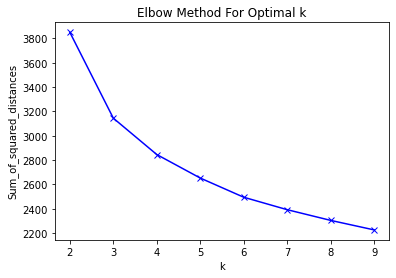

In [178]:
plt.plot(K, Sum_of_squared_distances, "bx-")
plt.xlabel("k")
plt.ylabel("Sum_of_squared_distances")
plt.title("Elbow Method For Optimal k")
plt.show()

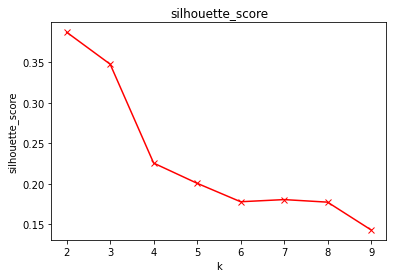

In [180]:
plt.plot(K, silho_scores, "rx-")
plt.xlabel("k")
plt.ylabel("silhouette_score")
plt.title("silhouette_score")
plt.show()